### Loading Packages and Data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
ls /ihme/costeffectiveness/results/vivarium_nih_us_cvd/model_6/alabama/2022_11_01_15_10_44/

__pycache__/   keyspace.yaml             output.hdf
branches.yaml  logs/                     requirements.txt
count_data/    model_specification.yaml  settings.py


In [3]:
ls /ihme/costeffectiveness/results/vivarium_nih_us_cvd/model_6/alabama/2022_11_01_15_10_44/count_data

deaths.csv                       sbp_medication_person_time.csv
deaths.hdf                       sbp_medication_person_time.hdf
healthcare_visits.csv            state_person_time.csv
healthcare_visits.hdf            state_person_time.hdf
ldlc_medication_person_time.csv  transition_count.csv
ldlc_medication_person_time.hdf  transition_count.hdf
population.csv                   ylds.csv
population.hdf                   ylds.hdf
risk_exposure_time.csv           ylls.csv
risk_exposure_time.hdf           ylls.hdf


In [4]:
sim_results_dir = '/ihme/costeffectiveness/results/vivarium_nih_us_cvd/model_6/alabama/2022_11_01_15_10_44/count_data/'

### Exploring Data

In [5]:
deaths = pd.read_csv(sim_results_dir + 'deaths.csv')
deaths.head()

,Unnamed: 0,sex,year,cause,measure,input_draw,scenario,age,value
0,0,female,2023,acute_ischemic_stroke,deaths,29,baseline,25_to_29,0
1,1,female,2023,acute_ischemic_stroke,deaths,29,baseline,30_to_34,0
2,2,female,2023,acute_ischemic_stroke,deaths,29,baseline,35_to_39,0
3,3,female,2023,acute_ischemic_stroke,deaths,29,baseline,40_to_44,0
4,4,female,2023,acute_ischemic_stroke,deaths,29,baseline,45_to_49,0


In [6]:
pop = pd.read_csv(sim_results_dir + 'population.csv')
pop.loc[pop.measure=="total_population_untracked"].value.sum()
pop.head()

,Unnamed: 0,measure,input_draw,scenario,value
0,0,total_population,29,baseline,750000
1,1,total_population,232,baseline,750000
2,2,total_population,357,baseline,750000
3,3,total_population,394,baseline,750000
4,4,total_population,602,baseline,750000


In [7]:
tran = pd.read_csv(sim_results_dir + 'transition_count.csv')
tran.transition.unique()

array(['angina_susceptible_to_angina_to_angina',
       'ischemic_stroke_acute_ischemic_stroke_to_chronic_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke_to_acute_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke',
       'myocardial_infarction_acute_myocardial_infarction_to_post_myocardial_infarction',
       'myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction',
       'myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction'],
      dtype=object)

In [8]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["ischemic_stroke_acute_ischemic_stroke", "ischemic_stroke_chronic_ischemic_stroke", "ischemic_stroke_susceptible_to_ischemic_stroke"])].reset_index() 
person_time.value.sum()

102496276.10677618

In [9]:
person_time_test = state_person_time.loc[state_person_time['state'].isin(["myocardial_infarction_acute_myocardial_infarction", "myocardial_infarction_post_myocardial_infarction", "myocardial_infarction_susceptible_to_myocardial_infarction"])].reset_index() 
person_time_test.value.sum()

102496276.10677618

### Total DALYs by Year

In [10]:
yll = pd.read_csv(sim_results_dir + 'ylls.csv')
yll = yll.rename(columns = {'value':'yll'})
yll_total = yll.groupby(['sex', 'age', 'input_draw', 'year']).yll.sum().reset_index()
yld = pd.read_csv(sim_results_dir + 'ylds.csv')
yld = yld.rename(columns = {'value':'yld'})
yld_total = yld.groupby(['sex', 'age', 'input_draw', 'year']).yld.sum().reset_index()
daly_total = pd.concat([yll_total, yld_total.yld], axis=1)
daly_total['daly'] = daly_total['yll'] + daly_total['yld'] 

daly_total.head()

,sex,age,input_draw,year,yll,yld,daly
0,female,25_to_29,29,2023,1681.272527,28.993611,1710.266137
1,female,25_to_29,29,2024,2529.366915,27.796020,2557.162934
2,female,25_to_29,29,2025,1849.490238,28.017663,1877.507901
3,female,25_to_29,29,2026,2530.268365,28.186495,2558.454860
4,female,25_to_29,29,2027,1899.008308,27.502820,1926.511128


In [11]:
daly_sum = (daly_total
                .groupby(['year'])
                .daly.describe(percentiles=[.025, .975])
                .filter(['mean', '2.5%', '97.5%'])
                .reset_index())

daly_sum.head()

,year,mean,2.5%,97.5%
0,2023,5907.741782,749.899975,12744.625864
1,2024,6043.783572,783.381448,12737.779398
2,2025,6032.602231,847.058483,12942.706498
3,2026,6092.732729,855.397271,13210.394334
4,2027,6148.715100,923.442754,13147.285881


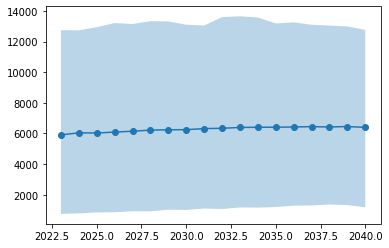

In [12]:
plt.plot(daly_sum['year'], daly_sum['mean'], marker = 'o')
plt.fill_between(daly_sum['year'], daly_sum['2.5%'], daly_sum['97.5%'], alpha = 0.3)

### All Cause Mortality Graphs

In [13]:
result_summary = (deaths
                      .groupby(['age', 'sex', 'year'])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,5.283333,0.0,31.050
1,25_to_29,female,2024,5.883333,0.0,35.050
2,25_to_29,female,2025,5.033333,0.0,30.050
3,25_to_29,female,2026,5.233333,0.0,35.525
4,25_to_29,female,2027,5.250000,0.0,32.625


In [14]:
%%capture 
from matplotlib.backends.backend_pdf import PdfPages # PDF package

with PdfPages('raw_mortality_counts_model6.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure()             
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Raw death counts: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=1000)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

#### All Cause Mortality Graph with Rate

In [15]:
person_time = person_time.rename(columns = {'value':'ptvalue'})
per_time_group = person_time.groupby(['age', 'sex', 'year', 'input_draw']).ptvalue.sum().reset_index()

per_time_group.head()

,age,sex,year,input_draw,ptvalue
0,25_to_29,female,2023,29,27465.374401
1,25_to_29,female,2023,232,27792.788501
2,25_to_29,female,2023,357,27624.366872
3,25_to_29,female,2023,394,27461.311431
4,25_to_29,female,2023,602,27431.260780


In [16]:
results_rate = deaths.groupby(['age', 'sex', 'year', 'input_draw']).value.sum().reset_index()
results_rate = pd.concat([results_rate, per_time_group.ptvalue], axis=1)
results_rate['mean_rate'] = results_rate['value'] / results_rate['ptvalue']
result_summary = (results_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.001150,0.000874,0.001543
1,25_to_29,female,2024,0.001295,0.000936,0.001660
2,25_to_29,female,2025,0.001117,0.000886,0.001463
3,25_to_29,female,2026,0.001168,0.000754,0.001643
4,25_to_29,female,2027,0.001176,0.000821,0.001541


In [17]:
%%capture 
with PdfPages('acmr_model6.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for year in result_summary.year.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'ACMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.4)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [18]:
%%capture 
## Has age and year reversed, so looking at year trend by age group now. 
with PdfPages('acmr_by_year_model6.pdf') as pdf:
    for sex in result_summary.sex.unique():
        for age in result_summary.age.unique():
            plt.figure() 
            subdata = result_summary.loc[(result_summary.sex==sex) & (result_summary.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'ACMR: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymin=0) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Cause Specific Mortality Graphs
#### Acute Stroke

In [19]:
deaths_cause = (deaths
               .groupby(['age', 'sex', 'year', 'cause'])
               .value.describe(percentiles=[.025, .975])
               .filter(['mean', '2.5%', '97.5%'])
               .reset_index())

acute = deaths_cause.loc[(deaths_cause['cause'] == 'acute_ischemic_stroke')].reset_index()

acute.head()

,index,age,sex,year,cause,mean,2.5%,97.5%
0,0,25_to_29,female,2023,acute_ischemic_stroke,0.1,0.0,0.775
1,6,25_to_29,female,2024,acute_ischemic_stroke,0.0,0.0,0.000
2,12,25_to_29,female,2025,acute_ischemic_stroke,0.1,0.0,0.775
3,18,25_to_29,female,2026,acute_ischemic_stroke,0.0,0.0,0.000
4,24,25_to_29,female,2027,acute_ischemic_stroke,0.0,0.0,0.000


In [20]:
death_rate_cause = deaths.groupby(['age', 'sex', 'year', 'input_draw', 'cause']).value.sum().reset_index()
acute_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_ischemic_stroke')].reset_index()
acute_rate.head()

,index,age,sex,year,input_draw,cause,value
0,0,25_to_29,female,2023,29,acute_ischemic_stroke,0
1,6,25_to_29,female,2023,232,acute_ischemic_stroke,0
2,12,25_to_29,female,2023,357,acute_ischemic_stroke,0
3,18,25_to_29,female,2023,394,acute_ischemic_stroke,0
4,24,25_to_29,female,2023,602,acute_ischemic_stroke,0


In [21]:
acute_rate_2 = pd.concat([acute_rate, per_time_group.ptvalue], axis=1)
acute_rate_2['mean_rate'] = acute_rate_2['value'] / acute_rate_2['ptvalue']

acute_rate_summary = (acute_rate_2
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_summary.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000004,0.0,0.000028
1,25_to_29,female,2024,0.000000,0.0,0.000000
2,25_to_29,female,2025,0.000004,0.0,0.000029
3,25_to_29,female,2026,0.000000,0.0,0.000000
4,25_to_29,female,2027,0.000000,0.0,0.000000


In [22]:
%%capture 
with PdfPages('acute_stroke_csmr_model6.pdf') as pdf:
    for sex in acute_rate_summary.sex.unique():
        for year in acute_rate_summary.year.unique():
            plt.figure() 
            subdata = acute_rate_summary.loc[(acute_rate_summary.sex==sex) & (acute_rate_summary.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            plt.ylabel('CSMR for Acute Stroke') 
            pdf.savefig(bbox_inches='tight')

#### Chronic Stroke

In [23]:
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate = pd.concat([chronic_rate, per_time_group.ptvalue], axis=1)
chronic_rate['mean_rate'] = chronic_rate['value'] / chronic_rate['ptvalue']
chronic_rate_summ = (chronic_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

chronic_rate_summ

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000000,0.000000,0.000000
1,25_to_29,female,2024,0.000000,0.000000,0.000000
2,25_to_29,female,2025,0.000000,0.000000,0.000000
3,25_to_29,female,2026,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
536,95_plus,male,2037,0.009722,0.003659,0.013104
537,95_plus,male,2038,0.009148,0.002503,0.018603
538,95_plus,male,2039,0.008643,0.004287,0.013617
539,95_plus,male,2040,0.008394,0.002656,0.012607


In [24]:
%%capture
with PdfPages('chronic_stroke_csmr_model6.pdf') as pdf:
    for sex in chronic_rate_summ.sex.unique():
        for year in chronic_rate_summ.year.unique():
            plt.figure() 
            subdata = chronic_rate_summ.loc[(chronic_rate_summ.sex==sex) & (chronic_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Chronic Stroke CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            plt.ylabel('CSMR for Chronic Stroke') 
            pdf.savefig(bbox_inches='tight')

#### Acute Myocardial Infarction

In [25]:
death_rate_cause.cause.unique()

array(['acute_ischemic_stroke', 'acute_myocardial_infarction', 'angina',
       'chronic_ischemic_stroke', 'other_causes',
       'post_myocardial_infarction'], dtype=object)

In [26]:
acute_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_rate = pd.concat([acute_MI_rate, per_time_group.ptvalue], axis=1)
acute_MI_rate['mean_rate'] = acute_MI_rate['value'] / acute_MI_rate['ptvalue']
acute_MI_rate_summ = (acute_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000127,0.000044,0.000265
1,25_to_29,female,2024,0.000132,0.000036,0.000305
2,25_to_29,female,2025,0.000104,0.000017,0.000213
3,25_to_29,female,2026,0.000097,0.000037,0.000149
4,25_to_29,female,2027,0.000093,0.000008,0.000199


In [27]:
%%capture
with PdfPages('acute_MI_csmr_model6.pdf') as pdf:
    for sex in acute_MI_rate_summ.sex.unique():
        for year in acute_MI_rate_summ.year.unique():
            plt.figure() 
            subdata = acute_MI_rate_summ.loc[(acute_MI_rate_summ.sex==sex) & (acute_MI_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute MI CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.03)
            plt.grid()
            plt.ylabel('CSMR for Acute MI') 
            pdf.savefig(bbox_inches='tight')

#### Post Myocaridal Infarction

In [28]:
post_MI_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_rate = pd.concat([post_MI_rate, per_time_group.ptvalue], axis=1)
post_MI_rate['mean_rate'] = post_MI_rate['value'] / post_MI_rate['ptvalue']
post_MI_rate_summ = (post_MI_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000047,0.000000,0.000109
1,25_to_29,female,2024,0.000070,0.000008,0.000138
2,25_to_29,female,2025,0.000063,0.000037,0.000139
3,25_to_29,female,2026,0.000078,0.000000,0.000148
4,25_to_29,female,2027,0.000060,0.000000,0.000141


In [29]:
%%capture
with PdfPages('post_MI_csmr_model6.pdf') as pdf:
    for sex in post_MI_rate_summ.sex.unique():
        for year in post_MI_rate_summ.year.unique():
            plt.figure() 
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [30]:
%%capture
with PdfPages('post_MI_csmr_byyear_model6.pdf') as pdf:
    for sex in post_MI_rate_summ.sex.unique():
        for age in post_MI_rate_summ.age.unique():
            plt.figure() 
            subdata = post_MI_rate_summ.loc[(post_MI_rate_summ.sex==sex) & (post_MI_rate_summ.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI CSMR by Year: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Angina

In [31]:
angina_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'angina')].reset_index()
angina_rate = pd.concat([angina_rate, per_time_group.ptvalue], axis=1)
angina_rate['mean_rate'] = angina_rate['value'] / angina_rate['ptvalue']
angina_rate_summ = (angina_rate
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

angina_rate_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000033,0.0,0.000101
1,25_to_29,female,2024,0.000051,0.0,0.000139
2,25_to_29,female,2025,0.000041,0.0,0.000131
3,25_to_29,female,2026,0.000019,0.0,0.000066
4,25_to_29,female,2027,0.000041,0.0,0.000112


In [32]:
%%capture
with PdfPages('angina_csmr_model6.pdf') as pdf:
    for sex in angina_rate_summ.sex.unique():
        for year in angina_rate_summ.year.unique():
            plt.figure() 
            subdata = angina_rate_summ.loc[(angina_rate_summ.sex==sex) & (angina_rate_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Angina CSMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.ylim(ymax=0.01)
            plt.grid()
            plt.ylabel('CSMR for Angina') 
            pdf.savefig(bbox_inches='tight')

### Excess Mortality rate

#### Post Myocardial Infarction

In [33]:
per_time_state = state_person_time.groupby(['age', 'sex', 'year', 'state', 'input_draw']).value.sum().reset_index()
per_time_state = per_time_state.rename(columns = {'value':'ptvalue'})
per_time_post_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_post_myocardial_infarction')].reset_index()

post_MI_emr = death_rate_cause.loc[(death_rate_cause['cause'] == 'post_myocardial_infarction')].reset_index()
post_MI_emr = pd.concat([post_MI_emr, per_time_post_MI.ptvalue], axis=1)
post_MI_emr['mean_rate'] = post_MI_emr['value'] / post_MI_emr['ptvalue']
post_MI_emr_summ = (post_MI_emr
                      .groupby(['age', 'sex', 'year'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

post_MI_emr_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.033572,0.000000,0.088639
1,25_to_29,female,2024,0.048691,0.004884,0.097305
2,25_to_29,female,2025,0.043302,0.023571,0.091758
3,25_to_29,female,2026,0.049894,0.000000,0.097209
4,25_to_29,female,2027,0.040415,0.000000,0.107830


In [34]:
%%capture
with PdfPages('post_MI_emr_model6.pdf') as pdf:
    for sex in post_MI_emr_summ.sex.unique():
        for year in post_MI_emr_summ.year.unique():
            plt.figure() 
            subdata = post_MI_emr_summ.loc[(post_MI_emr_summ.sex==sex) & (post_MI_emr_summ.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Post MI EMR: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Prevalence 

#### Chronic + Acute Stroke

In [35]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
prev_acute = prev_acute.rename(columns = {'ptvalue':'value'})
prev_acute_rate = pd.concat([prev_acute, per_time_group.ptvalue], axis=1)
prev_acute_rate['rate']= prev_acute_rate['value'] / prev_acute_rate['ptvalue']
prev_acute_rate_sum = (prev_acute_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

prev_acute_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000012,3.411372e-06,0.000022
1,25_to_29,female,2024,0.000013,2.812696e-06,0.000032
2,25_to_29,female,2025,0.000012,6.342852e-07,0.000029
3,25_to_29,female,2026,0.000009,6.368832e-07,0.000020
4,25_to_29,female,2027,0.000010,6.444369e-07,0.000022


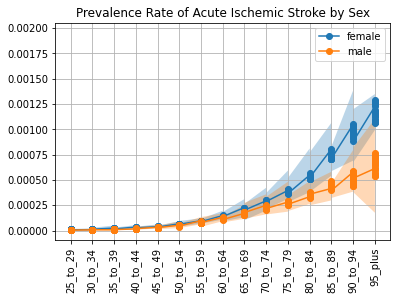

In [36]:
groups = prev_acute_rate_sum.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Acute Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [37]:
prev_chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
prev_chronic = prev_chronic.rename(columns = {'ptvalue':'value'})
prev_chronic_rate = pd.concat([prev_chronic, per_time_group.ptvalue], axis=1)
prev_chronic_rate['rate']= prev_chronic_rate['value'] / prev_chronic_rate['ptvalue']
prev_chronic_rate_sum = (prev_chronic_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

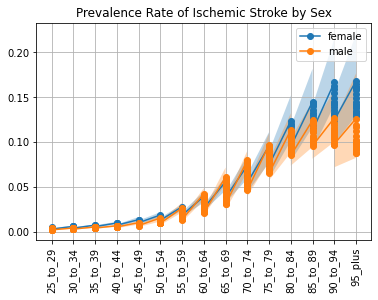

In [38]:
groups = prev_chronic_rate_sum.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

#### Myocardial Infarction

In [39]:
prev_acute_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_acute_myocardial_infarction')].reset_index()
prev_acute_MI = prev_acute_MI.rename(columns = {'ptvalue':'value'})
prev_acute_MI = pd.concat([prev_acute_MI, per_time_group.ptvalue], axis=1)
prev_acute_MI['rate']= prev_acute_MI['value'] / prev_acute_MI['ptvalue']
prev_acute_MI_summ = (prev_acute_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000046,0.000022,0.000076
1,25_to_29,female,2024,0.000044,0.000022,0.000087
2,25_to_29,female,2025,0.000042,0.000019,0.000067
3,25_to_29,female,2026,0.000040,0.000020,0.000051
4,25_to_29,female,2027,0.000038,0.000021,0.000054


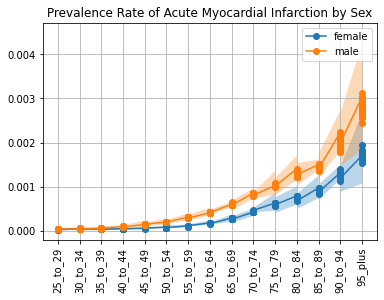

In [40]:
groups = prev_acute_MI_summ.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Prevalence Rate of Acute Myocardial Infarction by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [41]:
prev_post_MI = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_post_myocardial_infarction')].reset_index()
prev_post_MI = prev_post_MI.rename(columns = {'ptvalue':'value'})
prev_post_MI = pd.concat([prev_post_MI, per_time_group.ptvalue], axis=1)
prev_post_MI['rate']= prev_post_MI['value'] / prev_post_MI['ptvalue']
prev_post_MI_summ = (prev_post_MI
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.001493,0.001160,0.001825
1,25_to_29,female,2024,0.001477,0.001099,0.001861
2,25_to_29,female,2025,0.001451,0.001066,0.001862
3,25_to_29,female,2026,0.001591,0.001174,0.002031
4,25_to_29,female,2027,0.001623,0.001051,0.002088


In [42]:
%%capture
for sex in prev_post_MI_summ.sex.unique():
    for year in prev_post_MI_summ.year.unique():
        plt.figure() 
        subdata = prev_post_MI_summ.loc[(post_MI_rate_summ.sex==sex) & (prev_post_MI_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Post MI Prevalence: {year} {sex}') 
        plt.xticks(rotation=90) 
        plt.ylim(ymax=0.1)
        plt.grid()

### Angina

In [43]:
prev_angina = per_time_state.loc[(per_time_state['state'] == 'angina_angina')].reset_index()
prev_angina = prev_angina.rename(columns = {'ptvalue':'value'})
prev_angina = pd.concat([prev_angina, per_time_group.ptvalue], axis=1)
prev_angina['rate']= prev_angina['value'] / prev_angina['ptvalue']
prev_angina_summ = (prev_angina
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_angina_summ.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000182,0.000016,0.000310
1,25_to_29,female,2024,0.000168,0.000020,0.000351
2,25_to_29,female,2025,0.000160,0.000038,0.000308
3,25_to_29,female,2026,0.000171,0.000063,0.000312
4,25_to_29,female,2027,0.000156,0.000068,0.000289


In [44]:
%%capture
for sex in prev_angina_summ.sex.unique():
    for year in prev_angina_summ.year.unique():
        plt.figure() 
        subdata =prev_angina_summ.loc[(prev_angina_summ.sex==sex) & (prev_angina_summ.year==year)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        plt.title(f'Angina Prevalence: {year} {sex}') 
        plt.xticks(rotation=90) 
        plt.ylim(ymax=0.05)
        plt.grid()

### Incidence of First Time Acute Ischemic Stroke

In [45]:
tran.transition.unique()

array(['angina_susceptible_to_angina_to_angina',
       'ischemic_stroke_acute_ischemic_stroke_to_chronic_ischemic_stroke',
       'ischemic_stroke_chronic_ischemic_stroke_to_acute_ischemic_stroke',
       'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke',
       'myocardial_infarction_acute_myocardial_infarction_to_post_myocardial_infarction',
       'myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction',
       'myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction'],
      dtype=object)

In [46]:
tran_sum = (tran
                 .groupby(['age', 'sex', 'year', 'transition'])
                 .value.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_sum_stroke = tran_sum.loc[(tran_sum['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_sum_stroke.head()

,index,age,sex,year,transition,mean,2.5%,97.5%
0,3,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke...,3.9,1.225,7.550
1,10,25_to_29,female,2024,ischemic_stroke_susceptible_to_ischemic_stroke...,3.9,1.000,9.100
2,17,25_to_29,female,2025,ischemic_stroke_susceptible_to_ischemic_stroke...,3.2,1.000,6.550
3,24,25_to_29,female,2026,ischemic_stroke_susceptible_to_ischemic_stroke...,2.9,0.225,6.325
4,31,25_to_29,female,2027,ischemic_stroke_susceptible_to_ischemic_stroke...,2.7,0.000,5.775


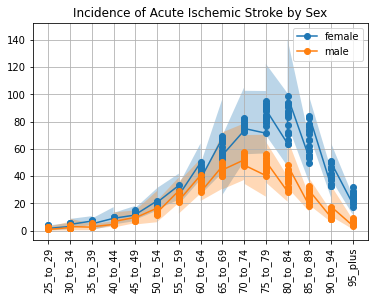

In [47]:
groups = tran_sum_stroke.groupby('sex')
for name, group in groups:
    plt.plot(group['age'], group['mean'], marker='o', label=name)
    plt.fill_between(group['age'], group['2.5%'], group['97.5%'], alpha=.3)
plt.title('Incidence of Acute Ischemic Stroke by Sex') 
plt.xticks(rotation=90) 
plt.grid()    
plt.legend()

In [48]:
per_time_sus_stroke = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_susceptible_to_ischemic_stroke')].reset_index()
per_time_sus_stroke.head()

,index,age,sex,year,state,input_draw,ptvalue
0,40,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,29,27310.444901
1,41,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,232,27657.330595
2,42,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,357,27492.511978
3,43,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,394,27317.190965
4,44,25_to_29,female,2023,ischemic_stroke_susceptible_to_ischemic_stroke,602,27282.234086


In [49]:
tran_rate = tran.groupby(['age', 'sex', 'year', 'transition', 'input_draw']).value.sum().reset_index()
tran_rate = tran_rate.loc[(tran_rate['transition'] == 'ischemic_stroke_susceptible_to_ischemic_stroke_to_acute_ischemic_stroke')].reset_index()
tran_rate = pd.concat([tran_rate, per_time_group.ptvalue], axis=1)
tran_rate['rate']= tran_rate['value'] / tran_rate['ptvalue']
tran_rate_sum = (tran_rate
                 .groupby(['age', 'sex', 'year'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

tran_rate_sum.head()

,age,sex,year,mean,2.5%,97.5%
0,25_to_29,female,2023,0.000142,0.000044,0.000274
1,25_to_29,female,2024,0.000143,0.000036,0.000334
2,25_to_29,female,2025,0.000118,0.000037,0.000242
3,25_to_29,female,2026,0.000108,0.000008,0.000236
4,25_to_29,female,2027,0.000101,0.000000,0.000215


In [50]:
%%capture
with PdfPages('acute_stroke_inc_model6.pdf') as pdf:
    for sex in tran_rate_sum.sex.unique():
        for age in tran_rate_sum.age.unique():
            plt.figure() 
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.age==age)]
            plt.plot(subdata['year'], subdata['mean'], marker='o')
            plt.fill_between(subdata['year'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute Stroke Incidence: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

In [51]:
%%capture
with PdfPages('acute_stroke_inc_byyear_model6.pdf') as pdf:
    for sex in tran_rate_sum.sex.unique():
        for year in tran_rate_sum.year.unique():
            plt.figure() 
            subdata = tran_rate_sum.loc[(tran_rate_sum.sex==sex) & (tran_rate_sum.year==year)]
            plt.plot(subdata['age'], subdata['mean'], marker='o')
            plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute Stroke Incidence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            pdf.savefig(bbox_inches='tight')

### Incidence of Acute Myocardial Infraction 

In [52]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(["myocardial_infarction_acute_myocardial_infarction", "myocardial_infarction_post_myocardial_infarction", "myocardial_infarction_susceptible_to_myocardial_infarction"])].reset_index() 
per_time_sus_MI = person_time.loc[(person_time['state'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction','myocardial_infarction_post_myocardial_infarction']))].reset_index()
tran_rate_MI = tran.loc[(tran['transition'].isin(['myocardial_infarction_susceptible_to_myocardial_infarction_to_acute_myocardial_infarction','myocardial_infarction_post_myocardial_infarction_to_acute_myocardial_infarction']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols).sum() / per_time_sus_MI.groupby(groupby_cols).sum()
tran_MI_summ = (tran_rate_MI_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 female 2023  0.000541  0.000260  0.000945
                2024  0.000568  0.000282  0.001075
                2025  0.000570  0.000239  0.000954
                2026  0.000543  0.000303  0.000663
                2027  0.000508  0.000306  0.000671

In [53]:
%%capture
with PdfPages('acute_MI_inc_model6.pdf') as pdf:
    for sex in tran_MI_summ.index.get_level_values('sex').unique():
        for year in tran_MI_summ.index.get_level_values('year').unique():
            plt.figure() 
            subdata = tran_MI_summ.loc[(tran_MI_summ.index.get_level_values('sex')==sex) & (tran_MI_summ.index.get_level_values('year')==year)]
            plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
            plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute MI Incidence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

In [116]:
%%capture
with PdfPages('acute_MI_inc_byyear_model6.pdf') as pdf:
    for sex in tran_MI_summ.index.get_level_values('sex').unique():
        for age in tran_MI_summ.index.get_level_values('age').unique():
            plt.figure() 
            subdata = tran_MI_summ.loc[(tran_MI_summ.index.get_level_values('sex')==sex) & (tran_MI_summ.index.get_level_values('age')==age)]
            plt.plot(subdata.index.get_level_values('year'), subdata['mean'], marker='o')
            plt.fill_between(subdata.index.get_level_values('year'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Acute MI Incidence: {age} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

### Angina 

In [54]:
state_person_time = pd.read_csv(sim_results_dir + '/state_person_time.csv')
person_time = state_person_time.loc[state_person_time['state'].isin(['angina_susceptible_to_angina'])].reset_index() 
tran_rate_angina = tran.loc[(tran['transition'].isin(['angina_susceptible_to_angina_to_angina']))].reset_index()
groupby_cols = ['age', 'sex', 'year', 'input_draw']
tran_rate_angina_all = tran_rate_angina.groupby(groupby_cols).sum() / person_time.groupby(groupby_cols).sum()
tran_angina_summ = (tran_rate_angina_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_angina_summ.head()

mean      2.5%     97.5%
age      sex    year                              
25_to_29 female 2023  0.000062  0.000008  0.000109
                2024  0.000077  0.000000  0.000240
                2025  0.000078  0.000037  0.000141
                2026  0.000041  0.000000  0.000103
                2027  0.000086  0.000008  0.000149

In [55]:
%%capture
with PdfPages('angina_inc_model6.pdf') as pdf:
    for sex in tran_angina_summ.index.get_level_values('sex').unique():
        for year in tran_angina_summ.index.get_level_values('year').unique():
            plt.figure() 
            subdata = tran_angina_summ.loc[(tran_angina_summ.index.get_level_values('sex')==sex) & (tran_angina_summ.index.get_level_values('year')==year)]
            plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
            plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
            plt.title(f'Angina Incidence: {year} {sex}') 
            plt.xticks(rotation=90) 
            plt.grid()
            plt.ylim(0,0.04)
            pdf.savefig(bbox_inches='tight')

### Artifacts

In [56]:
ls /mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/

alabama.hdf  washington.hdf


In [57]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [58]:
art_pop = art.load('population.structure').reset_index()
art_pop.head()

,location,sex,age_start,age_end,year_start,year_end,value
0,Alabama,Female,25.0,30.0,2019,2020,171101.787730
1,Alabama,Female,30.0,35.0,2019,2020,162707.127245
2,Alabama,Female,35.0,40.0,2019,2020,160738.561697
3,Alabama,Female,40.0,45.0,2019,2020,151811.937430
4,Alabama,Female,45.0,50.0,2019,2020,160780.871213


In [59]:
art.keys

['metadata.keyspace',
 'metadata.locations',
 'population.location',
 'population.structure',
 'population.age_bins',
 'population.demographic_dimensions',
 'population.theoretical_minimum_risk_life_expectancy',
 'cause.all_causes.cause_specific_mortality_rate',
 'sequela.acute_ischemic_stroke.prevalence',
 'sequela.chronic_ischemic_stroke.prevalence',
 'cause.ischemic_stroke.incidence_rate',
 'sequela.acute_ischemic_stroke.disability_weight',
 'sequela.chronic_ischemic_stroke.disability_weight',
 'sequela.acute_ischemic_stroke.excess_mortality_rate',
 'sequela.chronic_ischemic_stroke.excess_mortality_rate',
 'cause.ischemic_stroke.cause_specific_mortality_rate',
 'cause.ischemic_stroke.restrictions',
 'cause.acute_myocardial_infarction.prevalence',
 'cause.post_myocardial_infarction.prevalence',
 'cause.myocardial_infarction.incidence_rate',
 'cause.acute_myocardial_infarction.disability_weight',
 'cause.post_myocardial_infarction.disability_weight',
 'cause.acute_myocardial_infarctio

In [60]:
art_mort = art.load('sequela.acute_ischemic_stroke.excess_mortality_rate').reset_index()
art_mort.head()

,sex,age_start,age_end,year_start,year_end,draw_0,draw_1,draw_2,draw_3,draw_4,...,draw_990,draw_991,draw_992,draw_993,draw_994,draw_995,draw_996,draw_997,draw_998,draw_999
0,Female,25.0,30.0,2019,2020,0.31588,0.40003,0.32045,0.38893,0.24140,...,0.27915,0.29902,0.33340,0.28170,0.45043,0.26388,0.31837,0.28815,0.23798,0.20685
1,Female,30.0,35.0,2019,2020,0.30193,0.33175,0.28828,0.37140,0.24475,...,0.27680,0.29742,0.35445,0.23455,0.42553,0.22783,0.26775,0.28548,0.25033,0.25325
2,Female,35.0,40.0,2019,2020,0.28018,0.29485,0.27522,0.29580,0.32445,...,0.29240,0.29728,0.32355,0.24025,0.35158,0.27568,0.30525,0.40163,0.30818,0.44195
3,Female,40.0,45.0,2019,2020,0.24315,0.27495,0.29525,0.26428,0.35000,...,0.28105,0.31522,0.29495,0.24098,0.31315,0.28515,0.32320,0.41060,0.31078,0.45695
4,Female,45.0,50.0,2019,2020,0.19085,0.27205,0.34835,0.27682,0.32140,...,0.24275,0.35128,0.26865,0.23673,0.31025,0.25625,0.32160,0.31240,0.25812,0.29825


In [61]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: #in case there are other countries
        
        # grab main artifact object
        art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        # load requested measure
        data = art.load(word + '.' + cause + '.' + measure)
        
        # collapse to desired percentiles
        data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()
        
        # formatting (may want to format age as well)
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
   
        master_art_data = master_art_data.append(data)
        
    return master_art_data

#### All Cause Mortality Rates

In [62]:
art_acmr = load_artifact_data('cause', 'all_causes', 'cause_specific_mortality_rate')
art_acmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_acmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000950,0.000706,0.001237,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.001364,0.001029,0.001755,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.001697,0.001285,0.002179,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.002592,0.001978,0.003305,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.003660,0.002792,0.004668,Alabama,cause_specific_mortality_rate,45_to_49


In [63]:
result_summary_allyears = (results_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

result_summary_allyears.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.001146,0.000720,0.001635
1,25_to_29,male,0.002416,0.001766,0.003235
2,30_to_34,female,0.001536,0.000929,0.002109
3,30_to_34,male,0.002667,0.001983,0.003427
4,35_to_39,female,0.001821,0.001282,0.002364


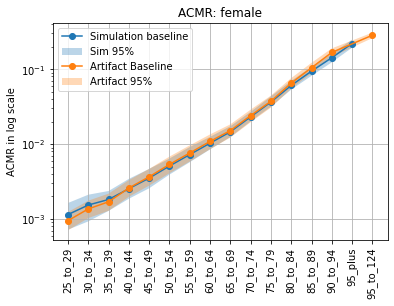

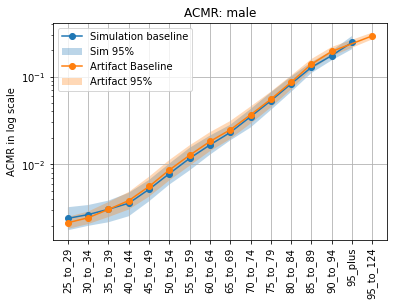

In [64]:
with PdfPages('acmr_artifact_and_sim_model6.pdf') as pdf:
    for sex in result_summary_allyears.sex.unique():
        plt.figure() 
        subdata = result_summary_allyears.loc[(result_summary_allyears.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_acmr.loc[(art_acmr.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'ACMR: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        plt.ylabel('ACMR in log scale')
        pdf.savefig(bbox_inches='tight')

### Cause Specific Mortality Rates

#### Stroke

In [65]:
art_csmr = load_artifact_data('cause', 'ischemic_stroke', 'cause_specific_mortality_rate') 
art_csmr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_acmr.age_start,art_acmr.age_end)]
art_csmr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000002,0.000001,0.000003,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000004,0.000002,0.000007,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000006,0.000003,0.000009,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000011,0.000007,0.000016,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000017,0.000011,0.000026,Alabama,cause_specific_mortality_rate,45_to_49


In [66]:
acute_rate_sum_allyear = (acute_rate_2
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [67]:
chronic_rate_allyear = (chronic_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [68]:
acute_rate_2 = acute_rate_2.rename(columns = {'mean_rate':'acute_rate'})
chronic_rate = chronic_rate.rename(columns = {'mean_rate':'chronic_rate'})
total_stroke_rate = pd.concat([acute_rate_2, chronic_rate.chronic_rate], axis=1)
total_stroke_rate['total_rate'] = total_stroke_rate['acute_rate'] + total_stroke_rate['chronic_rate']

In [69]:
total_stroke_rate_allyear = (total_stroke_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_stroke_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000002,0.0,0.000038
1,25_to_29,male,0.000004,0.0,0.000038
2,30_to_34,female,0.000005,0.0,0.000057
3,30_to_34,male,0.000004,0.0,0.000038
4,35_to_39,female,0.000007,0.0,0.000039


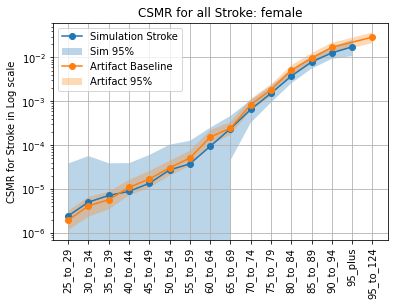

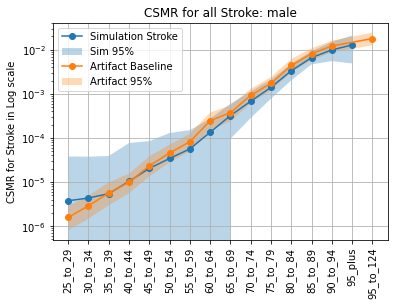

In [70]:
with PdfPages('csmr_stroke_artifact_and_sim_model6.pdf') as pdf:
    for sex in acute_rate_sum_allyear.sex.unique():
        plt.figure() 
        #subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
        #plt.plot(subdata['age'], subdata['mean'], marker='o')
        #plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        #subdata2 = chronic_rate_allyear.loc[(chronic_rate_allyear.sex==sex)]
        #plt.plot(subdata2['age'], subdata2['mean'], marker='o')
        #plt.fill_between(subdata2['age'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        subdata4 = total_stroke_rate_allyear.loc[(total_stroke_rate_allyear.sex==sex)]
        plt.plot(subdata4['age'], subdata4['mean'], marker='o')
        plt.fill_between(subdata4['age'], subdata4['2.5%'], subdata4['97.5%'], alpha=.3)
        subdata3 = art_csmr.loc[(art_csmr.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'CSMR for all Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.yscale('log')
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation Stroke', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        plt.ylabel('CSMR for Stroke in Log scale')
        pdf.savefig(bbox_inches='tight')

#### Myocardial Infarction

In [71]:
art_csmr2 = load_artifact_data('cause', 'myocardial_infarction', 'cause_specific_mortality_rate') 
art_csmr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_csmr2.age_start,art_csmr2.age_end)]
art_csmr2.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000017,0.000012,0.000024,Alabama,cause_specific_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000047,0.000034,0.000064,Alabama,cause_specific_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000098,0.000072,0.000132,Alabama,cause_specific_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000232,0.000165,0.000311,Alabama,cause_specific_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000393,0.000291,0.000513,Alabama,cause_specific_mortality_rate,45_to_49


In [72]:
acute_MI_rate_allyear = (acute_MI_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

In [73]:
post_MI_rate_allyear = (post_MI_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

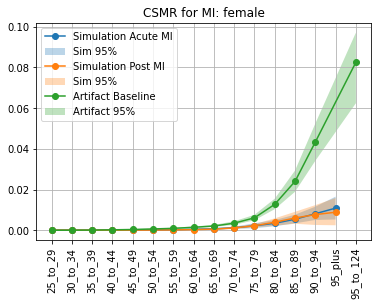

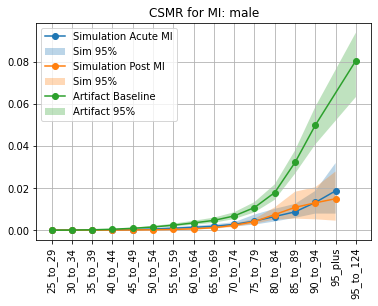

In [74]:
with PdfPages('model4vv_csmr_artifact_and_sim_model6.pdf') as pdf:
    for sex in acute_MI_rate_allyear.sex.unique():
        plt.figure() 
        subdata = acute_MI_rate_allyear.loc[(acute_MI_rate_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = post_MI_rate_allyear.loc[(post_MI_rate_allyear.sex==sex)]
        plt.plot(subdata2['age'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'CSMR for MI: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        #plt.yscale('log')
        plt.legend(['Simulation Acute MI', 'Sim 95%', 'Simulation Post MI', 'Sim 95%','Artifact Baseline', 'Artifact 95%']) 
        pdf.savefig(bbox_inches='tight')

In [75]:
acute_MI_rate = acute_MI_rate.rename(columns = {'mean_rate':'acute_rate'})
post_MI_rate = post_MI_rate.rename(columns = {'mean_rate':'post_rate'})
total_MI_rate = pd.concat([acute_MI_rate, post_MI_rate.post_rate], axis=1)
total_MI_rate['total_rate'] = total_MI_rate['acute_rate'] + total_MI_rate['post_rate']
total_MI_rate_allyear = (total_MI_rate
                      .groupby(['age', 'sex'])
                      .total_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
total_MI_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000177,0.000038,0.000370
1,25_to_29,male,0.000217,0.000045,0.000446
2,30_to_34,female,0.000160,0.000036,0.000354
3,30_to_34,male,0.000215,0.000037,0.000449
4,35_to_39,female,0.000127,0.000000,0.000279


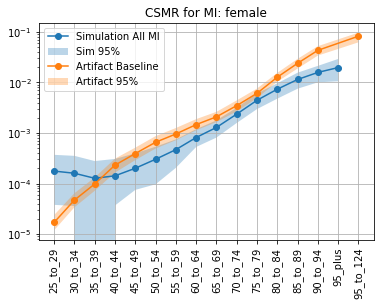

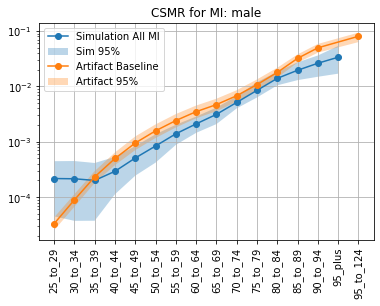

In [76]:
with PdfPages('csmr_MI_artifact_and_sim_model6.pdf') as pdf:
    for sex in total_MI_rate_allyear.sex.unique():
        plt.figure() 
        subdata = total_MI_rate_allyear.loc[(total_MI_rate_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata3 = art_csmr2.loc[(art_csmr2.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'CSMR for MI: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        pdf.savefig(bbox_inches='tight')

#### Incidence Rates for Stroke

In [77]:
art_inc = load_artifact_data('cause', 'ischemic_stroke', 'incidence_rate')
art_inc['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc.age_start,art_inc.age_end)]
art_inc.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000116,0.000050,0.000225,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000163,0.000091,0.000266,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000232,0.000128,0.000381,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000370,0.000242,0.000552,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000579,0.000343,0.000939,Alabama,incidence_rate,45_to_49


In [78]:
tran_rate_sum_allyear = (tran_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
tran_rate_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000109,0.000000,0.000307
1,25_to_29,male,0.000070,0.000000,0.000240
2,30_to_34,female,0.000163,0.000000,0.000411
3,30_to_34,male,0.000098,0.000000,0.000302
4,35_to_39,female,0.000229,0.000037,0.000561


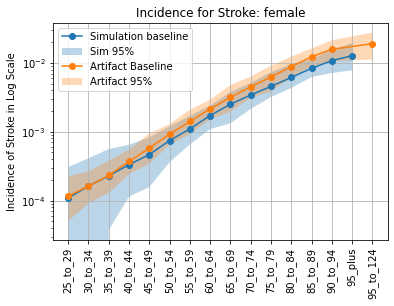

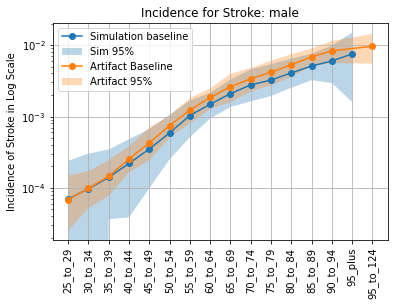

In [79]:
with PdfPages('inc_stroke_artifact_and_sim_model6.pdf') as pdf:
    for sex in tran_rate_sum_allyear.sex.unique():
        plt.figure() 
        subdata = tran_rate_sum_allyear.loc[(tran_rate_sum_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_inc.loc[(art_inc.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Incidence for Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        plt.ylabel('Incidence of Stroke in Log Scale')
        pdf.savefig(bbox_inches='tight')

#### Incidence Rates for MI

In [80]:
art_inc_acute_MI = load_artifact_data('cause', 'myocardial_infarction', 'incidence_rate')
art_inc_acute_MI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_acute_MI.age_start,art_inc_acute_MI.age_end)]
art_inc_acute_MI.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000452,0.000284,0.000616,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000510,0.000345,0.000683,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000426,0.000296,0.000581,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000540,0.000414,0.000690,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000850,0.000649,0.001110,Alabama,incidence_rate,45_to_49


In [81]:
groupby_cols2 = ['age', 'sex', 'input_draw']
tran_rate_MI_all = tran_rate_MI.groupby(groupby_cols2).sum() / per_time_sus_MI.groupby(groupby_cols2).sum()
tran_MI_summ_allyear = (tran_rate_MI_all.groupby([c for c in groupby_cols2 if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_MI_summ_allyear.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 female  0.000522  0.000320  0.000781
         male    0.000542  0.000344  0.000864
30_to_34 female  0.000534  0.000367  0.000769
         male    0.000623  0.000419  0.000899
35_to_39 female  0.000442  0.000337  0.000588

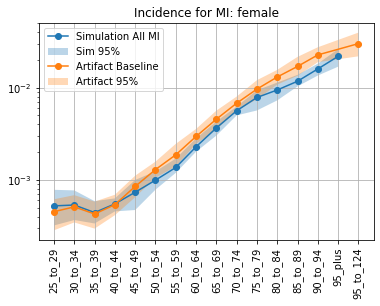

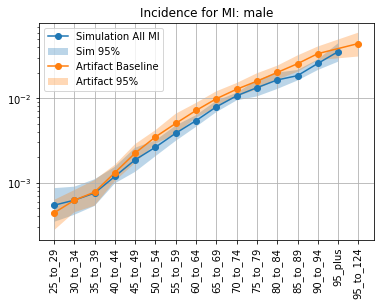

In [82]:
with PdfPages('inc_MI_artifact_and_sim_model6.pdf') as pdf:
    for sex in tran_MI_summ_allyear.index.get_level_values('sex').unique():
        plt.figure() 
        subdata = tran_MI_summ_allyear.loc[(tran_MI_summ_allyear.index.get_level_values('sex')==sex)]
        plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
        plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata3 = art_inc_acute_MI.loc[(art_inc_acute_MI.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'Incidence for MI: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%'])
        pdf.savefig(bbox_inches='tight')

### Angina

In [83]:
art_inc_angina = load_artifact_data('cause', 'angina', 'incidence_rate')
art_inc_angina['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_inc_angina.age_start, art_inc_angina.age_end)]
art_inc_angina.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000061,0.000042,0.000082,Alabama,incidence_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.000088,0.000060,0.000121,Alabama,incidence_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.000115,0.000075,0.000160,Alabama,incidence_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.000149,0.000109,0.000193,Alabama,incidence_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.000189,0.000108,0.000289,Alabama,incidence_rate,45_to_49


In [84]:
groupby_cols = ['age', 'sex']
tran_rate_angina_all = tran_rate_angina.groupby(groupby_cols).sum() / person_time.groupby(groupby_cols).sum()
tran_angina_summ = (tran_rate_angina_all.groupby([c for c in groupby_cols if c != 'input_draw'])
                   .value.describe(percentiles=[0.025, 0.975])
                   .filter(['mean', '2.5%', '97.5%']))
                 
tran_angina_summ.head()

mean      2.5%     97.5%
age      sex                                 
25_to_29 female  0.000073  0.000073  0.000073
         male    0.000112  0.000112  0.000112
30_to_34 female  0.000093  0.000093  0.000093
         male    0.000124  0.000124  0.000124
35_to_39 female  0.000119  0.000119  0.000119

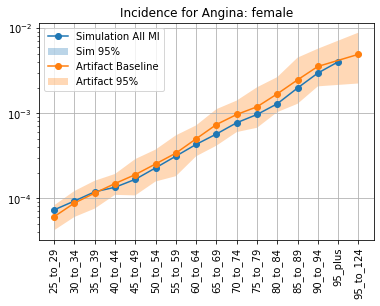

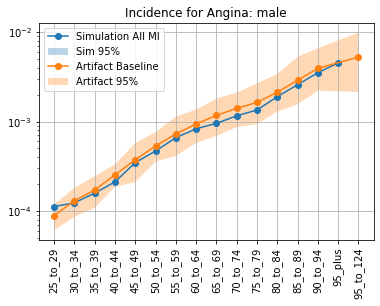

In [85]:
with PdfPages('inc_angina_artifact_and_sim_model6.pdf') as pdf:
    for sex in tran_angina_summ.index.get_level_values('sex').unique():
        plt.figure() 
        subdata = tran_angina_summ.loc[(tran_angina_summ.index.get_level_values('sex')==sex)]
        plt.plot(subdata.index.get_level_values('age'), subdata['mean'], marker='o')
        plt.fill_between(subdata.index.get_level_values('age'), subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata3 = art_inc_angina.loc[(art_inc_angina.sex==sex)]
        plt.plot(subdata3['age_group'], subdata3['mean'], marker='o')
        plt.fill_between(subdata3['age_group'], subdata3['2.5%'], subdata3['97.5%'], alpha=.3)
        plt.title(f'Incidence for Angina: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation All MI', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        pdf.savefig(bbox_inches='tight')

#### Prevalence Rates

In [86]:
prev_chronic_rate_sum_allyear = (prev_chronic_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [87]:
art_prev = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'prevalence')
art_prev['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev.age_start,art_prev.age_end)]
art_prev.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.004986,0.003708,0.006410,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.006119,0.004613,0.007857,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.007737,0.005971,0.010016,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.010115,0.007659,0.013100,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.014078,0.010695,0.018031,Alabama,prevalence,45_to_49


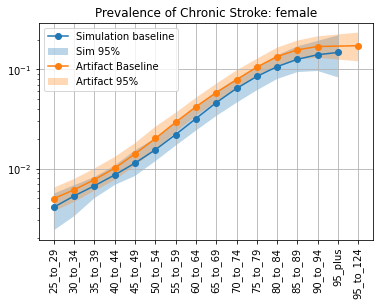

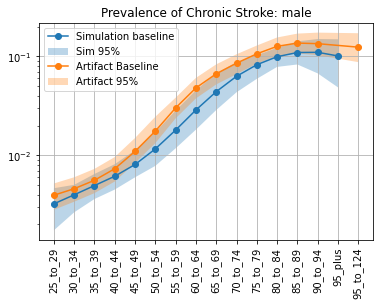

In [88]:
with PdfPages('prev_chronic_stroke_artifact_and_sim_model6.pdf') as pdf:
    for sex in prev_chronic_rate_sum_allyear.sex.unique():
        plt.figure() 
        subdata = prev_chronic_rate_sum_allyear.loc[(prev_chronic_rate_sum_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_prev.loc[(art_prev.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Prevalence of Chronic Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        pdf.savefig(bbox_inches='tight')

In [89]:
prev_acute_rate_sum_allyear = (prev_acute_rate
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())

In [90]:
art_prev2 = load_artifact_data('sequela', 'acute_ischemic_stroke', 'prevalence')
art_prev2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev2.age_start,art_prev2.age_end)]

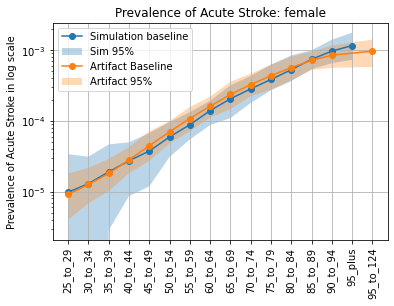

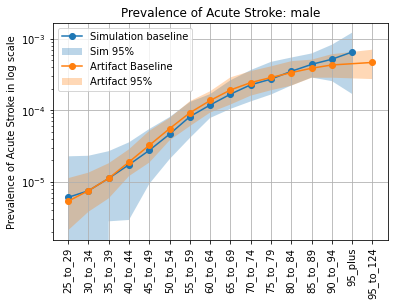

In [91]:
with PdfPages('prev_acute_stroke_artifact_and_sim_model6.pdf') as pdf:
    for sex in prev_acute_rate_sum_allyear.sex.unique():
        plt.figure() 
        subdata = prev_acute_rate_sum_allyear.loc[(prev_acute_rate_sum_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_prev2.loc[(art_prev2.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Prevalence of Acute Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        plt.ylabel('Prevalence of Acute Stroke in log scale')
        pdf.savefig(bbox_inches='tight')

#### Prevalence of Post MI

In [92]:
art_prev3 = load_artifact_data('cause', 'post_myocardial_infarction', 'prevalence')
art_prev3['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev3.age_start,art_prev3.age_end)]
art_prev3.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.001227,0.000904,0.001572,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.002536,0.001865,0.003277,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.004012,0.003125,0.005009,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.005660,0.004450,0.007101,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.007613,0.005996,0.009425,Alabama,prevalence,45_to_49


In [93]:
prev_post_MI_sum_allyear = (prev_post_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_post_MI_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.001568,0.001050,0.002170
1,25_to_29,male,0.001319,0.000845,0.001943
2,30_to_34,female,0.002994,0.002020,0.004445
3,30_to_34,male,0.002841,0.001869,0.004471
4,35_to_39,female,0.004548,0.003465,0.006353


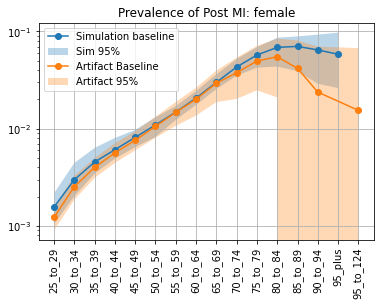

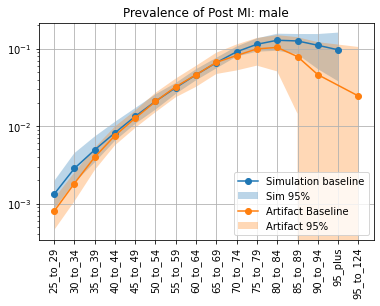

In [94]:
##Can try plotting the median 

with PdfPages('prev_post_MI_artifact_and_sim_model6.pdf') as pdf:
    for sex in prev_post_MI_sum_allyear.sex.unique():
        plt.figure() 
        subdata = prev_post_MI_sum_allyear.loc[(prev_post_MI_sum_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_prev3.loc[(art_prev3.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Prevalence of Post MI: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        pdf.savefig(bbox_inches='tight')

#### Prevalence of Acute MI

In [95]:
art_prev4 = load_artifact_data('cause', 'acute_myocardial_infarction', 'prevalence')
art_prev4['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev4.age_start,art_prev4.age_end)]
art_prev4.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000029,0.000019,0.000040,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.000036,0.000024,0.000048,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.000031,0.000022,0.000042,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.000037,0.000028,0.000048,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.000058,0.000044,0.000074,Alabama,prevalence,45_to_49


In [96]:
prev_acute_MI_sum_allyear = (prev_acute_MI
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_acute_MI_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000040,0.000012,0.000073
1,25_to_29,male,0.000041,0.000012,0.000078
2,30_to_34,female,0.000041,0.000018,0.000071
3,30_to_34,male,0.000048,0.000017,0.000088
4,35_to_39,female,0.000034,0.000014,0.000061


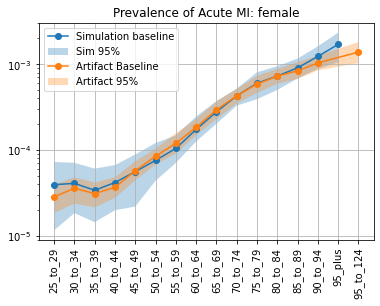

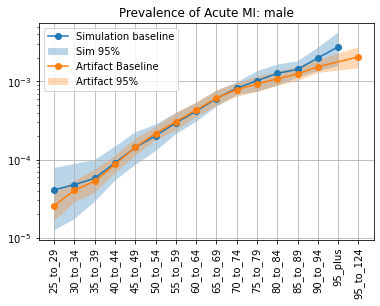

In [97]:
with PdfPages('prev_acute_MI_artifact_and_sim_model6.pdf') as pdf:
    for sex in prev_acute_MI_sum_allyear.sex.unique():
        plt.figure() 
        subdata = prev_acute_MI_sum_allyear.loc[(prev_acute_MI_sum_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_prev4.loc[(art_prev4.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Prevalence of Acute MI: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        pdf.savefig(bbox_inches='tight')

### Angina

In [98]:
art_prev_angina = load_artifact_data('cause', 'angina', 'prevalence')
art_prev_angina['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_prev_angina.age_start,art_prev_angina.age_end)]
art_prev_angina.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.000141,0.000093,0.000197,Alabama,prevalence,25_to_29
1,female,30.0,35.0,2019,2020,0.000289,0.000198,0.000390,Alabama,prevalence,30_to_34
2,female,35.0,40.0,2019,2020,0.000574,0.000381,0.000790,Alabama,prevalence,35_to_39
3,female,40.0,45.0,2019,2020,0.001131,0.000791,0.001517,Alabama,prevalence,40_to_44
4,female,45.0,50.0,2019,2020,0.001916,0.001455,0.002449,Alabama,prevalence,45_to_49


In [99]:
prev_angina_sum_allyear = (prev_angina
                 .groupby(['age', 'sex'])
                 .rate.describe(percentiles=[.025, .975])
                 .filter(['mean', '2.5%', '97.5%'])
                 .reset_index())
prev_angina_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000144,0.000010,0.000322
1,25_to_29,male,0.000208,0.000040,0.000441
2,30_to_34,female,0.000323,0.000128,0.000589
3,30_to_34,male,0.000385,0.000156,0.000722
4,35_to_39,female,0.000615,0.000361,0.001003


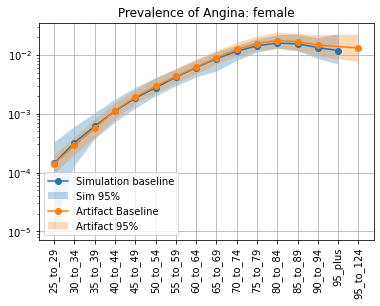

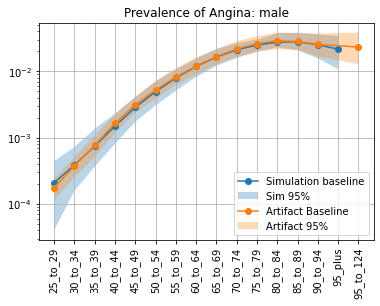

In [100]:
with PdfPages('prev_angina_artifact_and_sim_model6.pdf') as pdf:
    for sex in prev_angina_sum_allyear.sex.unique():
        plt.figure() 
        subdata = prev_angina_sum_allyear.loc[(prev_angina_sum_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_prev_angina.loc[(art_prev_angina.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Prevalence of Angina: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        pdf.savefig(bbox_inches='tight')

#### Excess Mortality Rate

#### Acute Stroke

In [101]:
art_emr = load_artifact_data('sequela', 'acute_ischemic_stroke', 'excess_mortality_rate')
art_emr['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr.age_start,art_emr.age_end)]
art_emr.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.309244,0.212204,0.442095,Alabama,excess_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.293380,0.198519,0.416337,Alabama,excess_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.323206,0.234077,0.432974,Alabama,excess_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.322984,0.238528,0.438779,Alabama,excess_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.292713,0.203912,0.393501,Alabama,excess_mortality_rate,45_to_49


In [102]:
prev_acute = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_acute_ischemic_stroke')].reset_index()
acute_rate_emr = pd.concat([acute_rate, prev_acute.ptvalue], axis=1)
acute_rate_emr['mean_rate'] = acute_rate_emr['value'] / acute_rate_emr['ptvalue']

acute_rate_sum_allyear = (acute_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())

acute_rate_sum_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.279089,0.0,2.228460
1,25_to_29,male,0.555974,0.0,6.522321
2,30_to_34,female,0.352685,0.0,3.994922
3,30_to_34,male,0.669625,0.0,6.522321
4,35_to_39,female,0.308276,0.0,3.261161


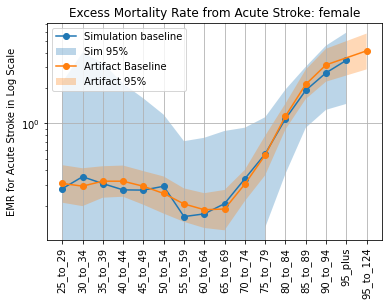

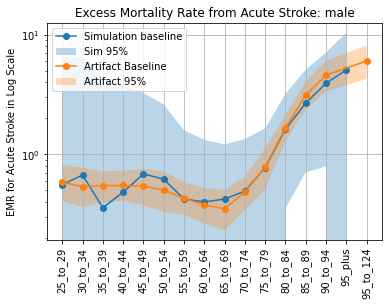

In [103]:
with PdfPages('emr_stroke_artifact_and_sim_model6.pdf') as pdf:
    for sex in acute_rate_sum_allyear.sex.unique():
        plt.figure() 
        subdata = acute_rate_sum_allyear.loc[(acute_rate_sum_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_emr.loc[(art_emr.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Excess Mortality Rate from Acute Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        plt.ylabel('EMR for Acute Stroke in Log Scale')
        pdf.savefig(bbox_inches='tight')

#### Chronic Stroke

In [104]:
art_emr2 = load_artifact_data('sequela', 'chronic_ischemic_stroke', 'excess_mortality_rate')
art_emr2['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr2.age_start,art_emr2.age_end)]

In [105]:
chronic = per_time_state.loc[(per_time_state['state'] == 'ischemic_stroke_chronic_ischemic_stroke')].reset_index()
#chronic = chronic.rename(columns = {'value':'ptvalue'})
chronic_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'chronic_ischemic_stroke')].reset_index()
chronic_rate_emr = pd.concat([chronic_rate, chronic.ptvalue], axis=1)
chronic_rate_emr['mean_rate'] = chronic_rate_emr['value'] / chronic_rate_emr['ptvalue']
chronic_rate_emr_allyear = (chronic_rate_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


chronic_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.000000,0.0,0.000000
1,25_to_29,male,0.000000,0.0,0.000000
2,30_to_34,female,0.000044,0.0,0.000000
3,30_to_34,male,0.000134,0.0,0.000000
4,35_to_39,female,0.000150,0.0,0.002553


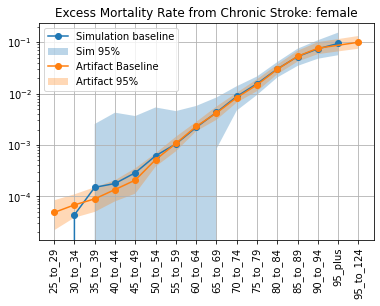

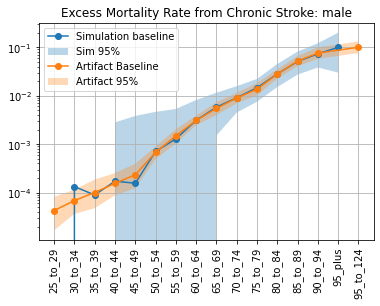

In [106]:
with PdfPages('emr_chronic_stroke_artifact_and_sim_model6.pdf') as pdf:
    for sex in chronic_rate_emr_allyear.sex.unique():
        plt.figure() 
        subdata = chronic_rate_emr_allyear.loc[(chronic_rate_emr_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_emr2.loc[(art_emr2.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Excess Mortality Rate from Chronic Stroke: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        pdf.savefig(bbox_inches='tight')

#### Acute MI

In [107]:
art_emr_acuteMI = load_artifact_data('cause', 'acute_myocardial_infarction', 'excess_mortality_rate')
art_emr_acuteMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_acuteMI.age_start,art_emr_acuteMI.age_end)]

In [108]:
acute_MI_EMR = per_time_state.loc[(per_time_state['state'] == 'myocardial_infarction_acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = death_rate_cause.loc[(death_rate_cause['cause'] == 'acute_myocardial_infarction')].reset_index()
acute_MI_emr_rate = pd.concat([acute_MI_emr_rate, acute_MI_EMR.ptvalue], axis=1)
acute_MI_emr_rate['mean_rate'] = acute_MI_emr_rate['value'] / acute_MI_emr_rate['ptvalue']
acute_MI_emr_rate_allyear = (acute_MI_emr_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


acute_MI_emr_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,2.920648,0.000000,7.146680
1,25_to_29,male,3.429124,0.387263,6.522321
2,30_to_34,female,2.217052,0.000000,5.699267
3,30_to_34,male,2.788642,0.000000,5.590561
4,35_to_39,female,1.751815,0.000000,5.062952


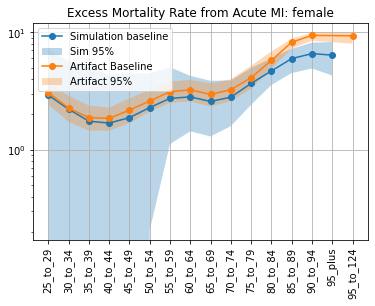

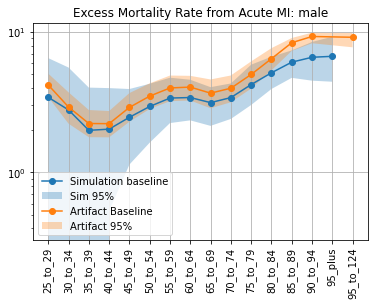

In [109]:
with PdfPages('emr_acute_MI_artifact_and_sim_model6.pdf') as pdf:
    for sex in acute_MI_emr_rate_allyear.sex.unique():
        plt.figure() 
        subdata = acute_MI_emr_rate_allyear.loc[(acute_MI_emr_rate_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_emr_acuteMI.loc[(art_emr_acuteMI.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Excess Mortality Rate from Acute MI: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        pdf.savefig(bbox_inches='tight')

#### Post MI EMR

In [110]:
post_mi_rate_emr_allyear = (post_MI_emr
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


post_mi_rate_emr_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.043405,0.0,0.117253
1,25_to_29,male,0.058629,0.0,0.143466
2,30_to_34,female,0.023396,0.0,0.062377
3,30_to_34,male,0.028349,0.0,0.075568
4,35_to_39,female,0.014607,0.0,0.038194


In [111]:
art_emr_postMI = load_artifact_data('cause', 'post_myocardial_infarction', 'excess_mortality_rate')
art_emr_postMI['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_postMI.age_start,art_emr_postMI.age_end)]

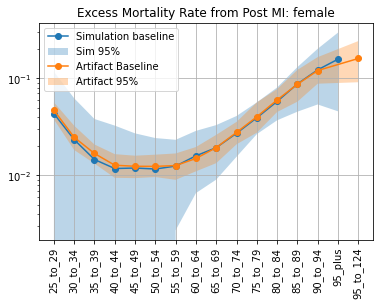

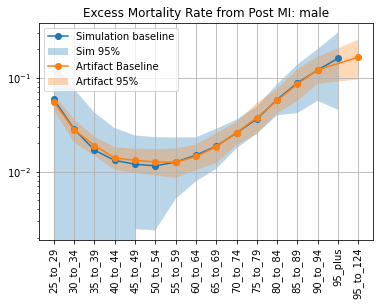

In [112]:
with PdfPages('emr_post_MI_artifact_and_sim_model6.pdf') as pdf:
    for sex in post_mi_rate_emr_allyear.sex.unique():
        plt.figure() 
        subdata = post_mi_rate_emr_allyear.loc[(post_mi_rate_emr_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_emr_postMI.loc[(art_emr_postMI.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Excess Mortality Rate from Post MI: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        pdf.savefig(bbox_inches='tight')

### Angina EMR

In [113]:
art_emr_angina = load_artifact_data('cause', 'angina', 'excess_mortality_rate')
art_emr_angina['age_group'] = [f'{int(i)}_to_{int(j) - 1}' for (i,j) in zip(art_emr_angina.age_start,art_emr_angina.age_end)]
art_emr_angina.head()

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,location,measure,age_group
0,female,25.0,30.0,2019,2020,0.282008,0.206508,0.368893,Alabama,excess_mortality_rate,25_to_29
1,female,30.0,35.0,2019,2020,0.173751,0.129001,0.225407,Alabama,excess_mortality_rate,30_to_34
2,female,35.0,40.0,2019,2020,0.065495,0.050426,0.083836,Alabama,excess_mortality_rate,35_to_39
3,female,40.0,45.0,2019,2020,0.009768,0.005119,0.016087,Alabama,excess_mortality_rate,40_to_44
4,female,45.0,50.0,2019,2020,0.006571,0.003868,0.010055,Alabama,excess_mortality_rate,45_to_49


In [114]:
angina_emr = per_time_state.loc[(per_time_state['state'] == 'angina_angina')].reset_index()
angina_death_cause = death_rate_cause.loc[(death_rate_cause['cause'] == 'angina')].reset_index()
angina_emr_rate = pd.concat([angina_death_cause, angina_emr.ptvalue], axis=1)
angina_emr_rate['mean_rate'] = angina_emr_rate['value'] / angina_emr_rate['ptvalue']
angina_emr_rate_allyear = (angina_emr_rate
                      .groupby(['age', 'sex'])
                      .mean_rate.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())


angina_emr_rate_allyear.head()

,age,sex,mean,2.5%,97.5%
0,25_to_29,female,0.304086,0.0,1.166542
1,25_to_29,male,0.376267,0.0,1.215524
2,30_to_34,female,0.157428,0.0,0.495257
3,30_to_34,male,0.235876,0.0,0.665573
4,35_to_39,female,0.069075,0.0,0.237966


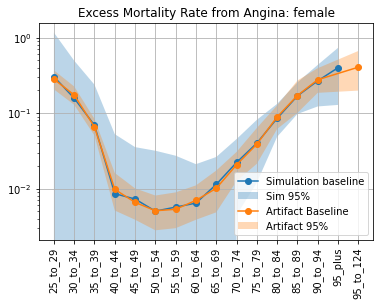

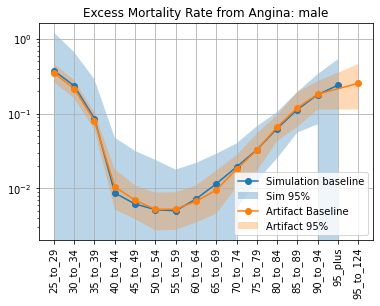

In [115]:
with PdfPages('emr_angina_artifact_and_sim_model6.pdf') as pdf:
    for sex in angina_emr_rate_allyear.sex.unique():
        plt.figure() 
        subdata = angina_emr_rate_allyear.loc[(angina_emr_rate_allyear.sex==sex)]
        plt.plot(subdata['age'], subdata['mean'], marker='o')
        plt.fill_between(subdata['age'], subdata['2.5%'], subdata['97.5%'], alpha=.3)
        subdata2 = art_emr_angina.loc[(art_emr_angina.sex==sex)]
        plt.plot(subdata2['age_group'], subdata2['mean'], marker='o')
        plt.fill_between(subdata2['age_group'], subdata2['2.5%'], subdata2['97.5%'], alpha=.3)
        plt.title(f'Excess Mortality Rate from Angina: {sex}') 
        plt.xticks(rotation=90) 
        plt.grid()
        plt.yscale('log')
        plt.legend(['Simulation baseline', 'Sim 95%', 'Artifact Baseline', 'Artifact 95%']) 
        pdf.savefig(bbox_inches='tight')